In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.stats as stats
import ROOT as r
import time
import ctypes
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')
%jsroot on

Welcome to JupyROOT 6.26/00


In [2]:
#get data and the corresponding histos
file=r.TFile("eta_histos.root","READ")
#events in +45 degree conf
hp45_list=[]
#... and -45 degree conf
hm45_list=[]
#and additionally, polarization
hp45pol_list=[]
hm45pol_list=[]
#c=r.TCanvas()
for i in range(4):
    hp45_list.append(file.Get(f"yield_p45_{i}"))
    hp45_list[i].Sumw2()
    hm45_list.append(file.Get(f"yield_m45_{i}"))
    hm45_list[i].Sumw2()
    hp45pol_list.append(file.Get(f"p45_pol_deg_{i}"))
    hp45pol_list[i].Sumw2()
    hm45pol_list.append(file.Get(f"m45_pol_deg_{i}"))
    hm45pol_list[i].Sumw2()
for i in range(4):    
    if(i==0 or i==2):
        hp45_list[i].Add(hp45_list[i+1])
        hm45_list[i].Add(hm45_list[i+1])
        
        hp45pol_list[i].Add(hp45pol_list[i+1])
        hm45pol_list[i].Add(hm45pol_list[i+1])
#already add up jul/aug (0) and sep/oct (1)
hp45=[hp45_list[0],hp45_list[2]]
hm45=[hm45_list[0],hm45_list[2]]
hp45pol=[hp45pol_list[0],hp45pol_list[2]]
hm45pol=[hm45pol_list[0],hm45pol_list[2]]
#hp45[0].ProjectionZ().Draw()
#c.Draw()

Warning in <TH3F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3F::Sumw2>: Sum of squares of weights structure al

In [3]:
df_list=[]
for i in range(0,11):
    #c=r.TCanvas()
    #c.Divide(4,3)
    #enum_list=[]
    
    for j in range(0,12):
        #c.cd(j+1)
        #project phi dist. in current bin
        costhetal=hp45[0].GetYaxis().GetBinLowEdge(j+1)
        costhetau=hp45[0].GetYaxis().GetBinUpEdge(j+1)
        #first two energy bins only july/august data
        if(i<=1):
            hp_tmp=hp45[0].ProjectionZ(hp45[0].GetName()+f"_pz{i,j}",i+1,i+1,j+1,j+1)
            #get associated errors
            hp_tmp_e=np.array([np.sqrt(hp_tmp.GetSumw2()[i+1])for i in range(12)])
            #print(hp_tmp_e)
            hm_tmp=hm45[0].ProjectionZ(hm45[0].GetName()+f"_pz{i,j}",i+1,i+1,j+1,j+1)
            #get associated errors
            hm_tmp_e=np.array([np.sqrt(hm_tmp.GetSumw2()[i+1])for i in range(12)])
            # get event based mean pol. values
            #get tmp th3 histos
            hp45pol0=hp45pol[0].Clone()
            hm45pol0=hm45pol[0].Clone()
            # get pol (e,ct,phi) by dividing by event yield
            hp45pol0.Divide(hp45[0])
            hm45pol0.Divide(hm45[0])
            #project in current bin
            hp45pol_tmp=hp45pol0.ProjectionZ(hp45pol0.GetName()+f"_pz{i,j}",i+1,i+1,j+1,j+1)
            hm45pol_tmp=hm45pol0.ProjectionZ(hm45pol0.GetName()+f"_pz{i,j}",i+1,i+1,j+1,j+1)
        #last two energy bins only sep/oct data    
        if(i>=9):
            hp_tmp=hp45[1].ProjectionZ(hp45[1].GetName()+f"_pz{i,j}",i-1,i-1,j+1,j+1)
            #get associated errors
            hp_tmp_e=np.array([np.sqrt(hp_tmp.GetSumw2()[i+1])for i in range(12)])
            #print(hp_tmp_e)
            hm_tmp=hm45[1].ProjectionZ(hm45[1].GetName()+f"_pz{i,j}",i-1,i-1,j+1,j+1)
            #get associated errors
            hm_tmp_e=np.array([np.sqrt(hm_tmp.GetSumw2()[i+1])for i in range(12)])
            # get event based mean pol. values
            #get tmp th3 histos
            hp45pol1=hp45pol[1].Clone()
            hm45pol1=hm45pol[1].Clone()
            # get pol (e,ct,phi) by dividing by event yield
            hp45pol1.Divide(hp45[1])
            hm45pol1.Divide(hm45[1])
            #project in current bin
            hp45pol_tmp=hp45pol1.ProjectionZ(hp45pol1.GetName()+f"_pz{i,j}",i-1,i-1,j+1,j+1)
            hm45pol_tmp=hm45pol1.ProjectionZ(hm45pol1.GetName()+f"_pz{i,j}",i-1,i-1,j+1,j+1)
            
        if(i>1 and i<9):
            hp_tmp=hp45[0].ProjectionZ(hp45[0].GetName()+f"_pz{i,j}",i+1,i+1,j+1,j+1)
            #get associated errors
            hp_tmp_e=np.array([np.sqrt(hp_tmp.GetSumw2()[i+1])for i in range(12)])
            #print(hp_tmp_e)
            hm_tmp=hm45[0].ProjectionZ(hm45[0].GetName()+f"_pz{i,j}",i+1,i+1,j+1,j+1)
            #get associated errors
            hm_tmp_e=np.array([np.sqrt(hm_tmp.GetSumw2()[i+1])for i in range(12)])
            #add other months
            hp_tmp_1=hp45[1].ProjectionZ(hp45[1].GetName()+f"_pz{i,j}",i-1,i-1,j+1,j+1)
            hp_tmp_1_e=np.array([np.sqrt(hp_tmp_1.GetSumw2()[i+1])for i in range(12)])
            hp_tmp.Add(hp_tmp_1)
        
            hm_tmp_1=hm45[1].ProjectionZ(hm45[1].GetName()+f"_pz{i,j}",i-1,i-1,j+1,j+1)
            hm_tmp_1_e=np.array([np.sqrt(hm_tmp_1.GetSumw2()[i+1])for i in range(12)])
            hm_tmp.Add(hm_tmp_1)
        
            #update errors
            hp_tmp_e=np.sqrt(hp_tmp_e**2+hp_tmp_1_e**2)
            hm_tmp_e=np.sqrt(hm_tmp_e**2+hm_tmp_1_e**2)
        

            # get event based mean pol. values
            hp45pol_tmp=hp45pol[0].ProjectionZ(hp45pol[0].GetName()+f"_pz{i,j}",i+1,i+1,j+1,j+1)
            hm45pol_tmp=hm45pol[0].ProjectionZ(hm45pol[0].GetName()+f"_pz{i,j}",i+1,i+1,j+1,j+1)
            # add other months if appropriate
            hp45pol_tmp.Add(hp45pol[1].ProjectionZ(hp45pol[1].GetName()+f"_pz{i,j}",i-1,i-1,j+1,j+1))
            hm45pol_tmp.Add(hm45pol[1].ProjectionZ(hm45pol[1].GetName()+f"_pz{i,j}",i-1,i-1,j+1,j+1))
            #get polarization
            hp45pol_tmp.Divide(hp_tmp)
            hm45pol_tmp.Divide(hm_tmp)
        
        
        #normalize event yields
        norm_p_err=ctypes.c_double(0.)
        norm_m_err=ctypes.c_double(0.)
        
        norm_p=hp_tmp.IntegralAndError(0,-1,norm_p_err,"")
        norm_m=hm_tmp.IntegralAndError(0,-1,norm_m_err,"")
        
        #clone histos before alterating them
        hnbot=hp_tmp.Clone()
        hnpar=hm_tmp.Clone()
        #normalize
        hp_tmp.Scale(1./norm_p)
        hm_tmp.Scale(1./norm_m)
        
        #build asymmetry
        
        enum=hp_tmp.Clone()
        enum.Add(hm_tmp,-1)
        
        
        hp_tmp.Multiply(hm45pol_tmp)
        hm_tmp.Multiply(hp45pol_tmp)
        
        nom=hp_tmp.Clone()
        nom.Add(hm_tmp)
        #gaussian error propagation
        final_e=[]
        for k in range(12):
            n_bot=hnbot.GetBinContent(k+1)
            n_bot_err=hp_tmp_e[k]
            #print(n_bot,n_bot_err)
            n_par=hnpar.GetBinContent(k+1)
            n_par_err=hm_tmp_e[k]
            pol_bot=hp45pol_tmp.GetBinContent(k+1)
            pol_par=hm45pol_tmp.GetBinContent(k+1)
            
            delta_nbot=np.sqrt(1/np.power(norm_p,4)*(np.power((norm_p-n_bot)*n_bot_err,2)
                                                     +n_bot*n_bot*(norm_p-n_bot)))
            delta_npar=np.sqrt(1/np.power(norm_m,4)*(np.power((norm_m-n_par)*n_par_err,2)
                                                     +n_par*n_par*(norm_m-n_par)))
            tmp_enum=(np.power(n_par/norm_m*(pol_bot+pol_par)*delta_nbot,2)
                        +np.power(n_bot/norm_p*(pol_bot+pol_par)*delta_npar,2))
            tmp_nom=np.power(pol_par*n_bot/norm_p+pol_bot*n_par/norm_m,4)
            #tmp_enum=((n_bot*n_par*norm_m*(pol_bot+pol_par)*norm_p_err.value)**2
            #        +(n_bot*n_par*norm_p*(pol_bot+pol_par)*norm_m_err.value)**2
            #        +(n_par*norm_p*norm_m*(pol_bot+pol_par)*n_bot_err)**2
            #        +(n_bot*norm_p*norm_m*(pol_bot+pol_par)*n_par_err)**2)
            #tmp_nom=np.power(pol_par*n_bot*norm_m+pol_bot*n_par*norm_p,4)
            
            
            final_e.append(np.sqrt(tmp_enum/tmp_nom))
        
        enum.Divide(nom)
        #set error
        #save the data in a dataframe!
        #create arrays with y,dy
        y=[]
        for k in range(12):
            enum.SetBinError(k+1,final_e[k])
            y.append(enum.GetBinContent(k+1))
        dic={}
        df_e=pd.DataFrame({f'ebin_{i}':[hp45[0].GetXaxis().GetBinLowEdge(i+1),hp45[0].GetXaxis().GetBinUpEdge(i+1)]})
        df_ct=pd.DataFrame({f'costheta_bin_{i,j}':[costhetal,costhetau]})
        dic[f'A_{i,j}']=y
        dic[f'dA_{i,j}']=final_e
        df_tmp=pd.DataFrame(data=dic)
        df_list.append(pd.concat([df_e,df_ct,df_tmp],axis=1))

In [4]:
df_x=pd.DataFrame({f'phi':[hp45[0].GetZaxis().GetBinCenter(k+1) for k in range(12)],
                           f'bin_phi':hp45[0].GetZaxis().GetBinWidth(1)})
final_df=pd.concat([df_x,*df_list],axis=1)
final_df.to_csv("./eta_data.csv")

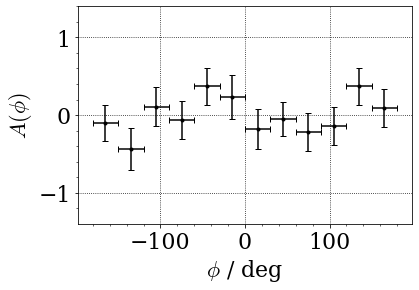

In [5]:
final_df=pd.read_csv('eta_data.csv')
i=8
j=3
x=final_df['phi']
dx=1/2*final_df['bin_phi']
y=final_df[f'A_{i,j}']
dy=final_df[f'dA_{i,j}']
fig, ax = plt.subplots()
ax.errorbar(x,y,xerr=dx,yerr=dy,fmt='.')
ax.set_xlabel("$\phi$ / deg")
ax.set_ylabel("$A(\phi)$")
ax.set_ylim([-1.4,1.4])
plt.show()